In [1]:
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd

# Lab 2
In this lab I calculate the speed of light and the latency per server hop. My estimation of the speed of light in a fiber optic at $2.27^{+.37}_{-.28}  \times 10^8$ m/s is within about 10% of the actual value at $2.054 \times 10^8$ m/s. By gathering data using  `ping` and `tracepath` I am able to get an estimate of distance and time. From there I use a weighted least squares approach to get C, T_h, time per hop, and errors on both of those parameters 

### 2.4.1
The speed of light in a  medium is the speed of light in a vacuum divided by the index of refraction. In the case of a fiber optic it is approximately 1.5, with an error I estimate of 5%. Furthermore I calculate the roundtrip time for a 1000km journey to be $$\frac{1.5 \times 10^6}{3 \times 10^8} = 2 \times 10^{-2} \text{seconds}$$

To perform the calculation with a 20m cable would require a timing accuracy on the range of 5 billionths of a second, which is about the fastest a computer could measure something.

# Methods 2.6
### 2.43, 2.5.1
I first use script.sh to generate a series of traces and pings. I then use dataCleaning.py to go through each trace, find the location of each hop, and generate the distance, number of cities, number of hops, time, and standard deviation of each ping. I then convert this into a pandas DataFrame
### 2.5.2 
For histograms of the sites, each site had a range of at most of 1 ms, so the histograms are uninteresting.

## Least Squares
 I started with the equation $\frac{D}{c}  + T_h \dot H = T$, where $D$ is the distance, $T_h$ is the time per hop, $H$ is number of hops, $c$ is speed of light, and $T$ is the time. From here I developed the matrix algorithm,  
$$ [ D H ] [P T_h ]^\top = \mathbf {T}$$
With $P$ being $\frac{1}{c}$

Since there is going to be no value of $[P T_h ]^\top$ that correctly solves this matrix for all my data points, I am going to need to find a $\boldsymbol {\beta }$ that minimizes the error. This can be done using a least squares method, which results in
$${\hat {\boldsymbol {\beta }}}=\left([ D H ] ^{\operatorname {T} }[ D H ] \right)^{-1}[ D H ]^{\operatorname {T} }\mathbf {T}$$
But this method does not take into account variances on the data, nor does it allow for an estimation of errors on the parameters $\boldsymbol {\beta }$
## Weighted Least Squares
Using a [weighted least squares](https://en.wikipedia.org/wiki/Weighted_least_squares) method allows for me to calculate $\boldsymbol {\beta }$, using a weighting matrix $W$, by
$${\hat {\boldsymbol {\beta }}}=\left([ D H ] ^{\operatorname {T}}W[ D H ] \right)^{-1}[ D H ]^{\operatorname {T} }W\mathbf {T}$$
And I can calculate the covariance matrix via
$$
\begin{aligned}
S&=r^{\textsf {T}}Wr \\
\chi _{\nu }^{2}&=S/\nu \\
M^{\beta }&=\chi _{\nu }^{2}\left([ D H ]^{\textsf {T}}W[ D H ]\right)^{-1}
\end{aligned}$$
where r is the residuals, and v is the degrees of freedom, which is the observations - the dimensions of the observations.

In [2]:
df = pd.read_json("data.json")
N = len(df)

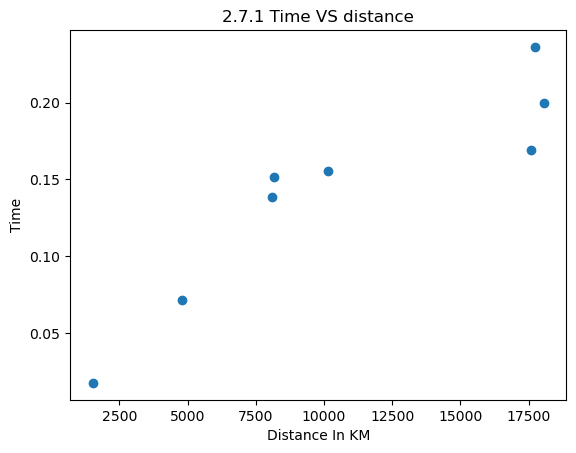

In [3]:
plt.scatter(df["Distances"]/1000, df["Times"])
plt.xlabel("Distance In KM")
plt.ylabel("Time")
plt.title("2.7.1 Time VS distance")
plt.show()

To calculate the weights matrix I find all of the fractional uncertainies, square them, add them, and place their reciprocal along the diagonal.

In [4]:
df["distanceVariances"] = (df["Cities"]*100000 / df["Distances"])**2

In [5]:
df["timeVariances"] = (df["Times Std. Dev"]/df["Times"])**2

In [6]:
df["hopVariances"] = .15**2

In [7]:
df["Total Fractional Variance"] =  df["hopVariances"] + df["distanceVariances"] + df["timeVariances"]

In [8]:
df

,Distances,Cities,Hops,Times,Times Std. Dev,distanceVariances,timeVariances,hopVariances,Total Fractional Variance
www.ecobank.com,8.092072e+06,3,21,0.138391,0.000108,0.001374,6.090204e-07,0.0225,0.023875
esunbank.com,1.805642e+07,4,18,0.199705,0.000035,0.000491,3.071554e-08,0.0225,0.022991
cam.ac.uk,8.166896e+06,3,29,0.151516,0.000041,0.001349,7.322354e-08,0.0225,0.023849
sun.ac.za,1.773149e+07,3,23,0.236213,0.000243,0.000286,1.058291e-06,0.0225,0.022787
berkeley.edu,1.527000e+06,5,14,0.017486,0.000031,0.107217,3.142986e-06,0.0225,0.129720
cern.ch,1.015903e+07,4,25,0.155244,0.000035,0.001550,5.082840e-08,0.0225,0.024050
sydney.edu.au,1.759449e+07,5,17,0.169283,0.000028,0.000808,2.735832e-08,0.0225,0.023308
ufl.edu,4.786594e+06,4,18,0.071181,0.000140,0.006983,3.868369e-06,0.0225,0.029487


In [9]:
weights = np.diagflat(1/(1+df["Total Fractional Variance"].to_numpy()))

In [10]:
DH = df[["Distances","Hops"]].to_numpy()
times = df["Times"].to_numpy()/2

I can then get an estimate for $\boldsymbol {\beta }$

In [11]:
Beta = np.linalg.inv(DH.transpose()@weights@DH)@DH.transpose()@weights@times
C = 1/Beta[0]
dof = N-2
C

228934966.66043326

This is a fairly good estimate for the speed of light in a fiber optic, which we would expect at approximately c/1.5, or about 200,000,000 m/s, due to the index of refraction in silica. But lets find out the errors on this estimate

In [12]:
df["Expected Times"] = 2*df[["Distances","Hops"]]@Beta

In [13]:
df["Residuals"] = (df["Times"] - df["Expected Times"])/2

$$
\begin{aligned}
S&=r^{\textsf {T}}Wr \\
\chi _{\nu }^{2}&=S/\nu \\
\end{aligned}$$

In [14]:
chiSquared = (df["Residuals"].values.transpose()@weights@df["Residuals"].values)/dof

$$
\begin{aligned}
M^{\beta }&=\chi _{\nu }^{2}\left([ D H ]^{\textsf {T}}W[ D H ]\right)^{-1}
\end{aligned}$$

In [15]:
Mbeta = chiSquared*np.linalg.inv(DH.transpose()@weights@DH) #This is the variance matrix for the estimated parameters, MBeta[i,i] is the estimated variance in the Beta[i] element

In [16]:
Mbeta[0,0]**.5 #This is the variance on the pace of light, pace being the term for the inverse of speed

6.141754517215566e-10

In [17]:
CLow = 1/(Beta[0]+Mbeta[0,0]**.5) #This is the low end estimate for the speed of light
CLow

200713409.51999232

In [18]:
CHigh = 1/(Beta[0]-Mbeta[0,0]**.5) #This is the high end estimate for the speed of light
CHigh
cLowerAndUpperErrors = np.array([C - CLow, CHigh - C])

In [19]:
df["Velocities"] = df["Distances"]/(.5*df["Times"])
df

,Distances,Cities,Hops,Times,Times Std. Dev,distanceVariances,timeVariances,hopVariances,Total Fractional Variance,Expected Times,Residuals,Velocities
www.ecobank.com,8.092072e+06,3,21,0.138391,0.000108,0.001374,6.090204e-07,0.0225,0.023875,0.123226,0.007583,1.169451e+08
esunbank.com,1.805642e+07,4,18,0.199705,0.000035,0.000491,3.071554e-08,0.0225,0.022991,0.202771,-0.001533,1.808309e+08
cam.ac.uk,8.166896e+06,3,29,0.151516,0.000041,0.001349,7.322354e-08,0.0225,0.023849,0.143892,0.003812,1.078024e+08
sun.ac.za,1.773149e+07,3,23,0.236213,0.000243,0.000286,1.058291e-06,0.0225,0.022787,0.212440,0.011887,1.501314e+08
berkeley.edu,1.527000e+06,5,14,0.017486,0.000031,0.107217,3.142986e-06,0.0225,0.129720,0.048362,-0.015438,1.746540e+08
cern.ch,1.015903e+07,4,25,0.155244,0.000035,0.001550,5.082840e-08,0.0225,0.024050,0.151289,0.001977,1.308782e+08
sydney.edu.au,1.759449e+07,5,17,0.169283,0.000028,0.000808,2.735832e-08,0.0225,0.023308,0.196234,-0.013475,2.078707e+08
ufl.edu,4.786594e+06,4,18,0.071181,0.000140,0.006983,3.868369e-06,0.0225,0.029487,0.086844,-0.007832,1.344908e+08


Text(0, 0.5, 'Predicted Velocity in m/s')

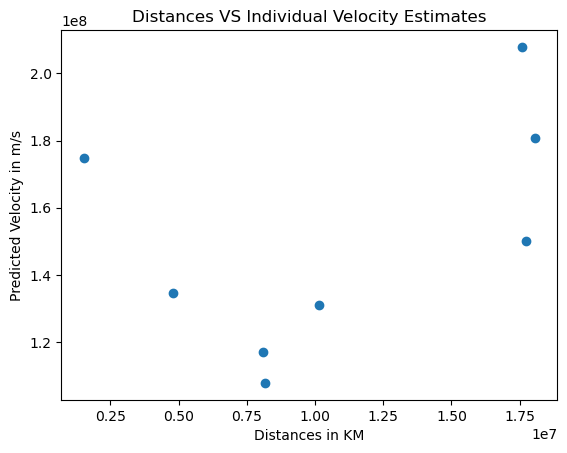

In [20]:
plt.scatter(df["Distances"],df["Velocities"])
plt.title("Distances VS Individual Velocity Estimates")
plt.xlabel("Distances in KM")
plt.ylabel("Predicted Velocity in m/s")

In [21]:
cLowerAndUpperErrors, C

(array([28221557.14044094, 37456269.11603788]), 228934966.66043326)

I estimate for the speed of light in a fiber optic is $2.27^{+.37}_{-.28}  \times 10^8$ m/s. Note the asymmetric errors due to the inverse of normally distributed estimates on $\frac{1}{c}$

In [22]:
df["Expected Time High Error Bars"] = abs(2 * (df["Distances"]/CLow + Beta[1]+Mbeta[1,1]**.5 * df["Hops"]) -df["Expected Times"])
df["Expected Time Low Error Bars"] = abs(2*df["Distances"]/CHigh -df["Expected Times"])
df["Observation Time Errors"] = df["Times"]*df["Total Fractional Variance"]**.5 #Here I calculate the estimated error on each on of my observations

In [23]:
#Above I calculate error bars for the next few graphs.
df

,Distances,Cities,Hops,Times,Times Std. Dev,distanceVariances,timeVariances,hopVariances,Total Fractional Variance,Expected Times,Residuals,Velocities,Expected Time High Error Bars,Expected Time Low Error Bars,Observation Time Errors
www.ecobank.com,8.092072e+06,3,21,0.138391,0.000108,0.001374,6.090204e-07,0.0225,0.023875,0.123226,0.007583,1.169451e+08,0.025024,0.062472,0.021384
esunbank.com,1.805642e+07,4,18,0.199705,0.000035,0.000491,3.071554e-08,0.0225,0.022991,0.202771,-0.001533,1.808309e+08,0.007432,0.067207,0.030281
cam.ac.uk,8.166896e+06,3,29,0.151516,0.000041,0.001349,7.322354e-08,0.0225,0.023849,0.143892,0.003812,1.078024e+08,0.039205,0.082577,0.023399
sun.ac.za,1.773149e+07,3,23,0.236213,0.000243,0.000286,1.058291e-06,0.0225,0.022787,0.212440,0.011887,1.501314e+08,0.016752,0.079316,0.035657
berkeley.edu,1.527000e+06,5,14,0.017486,0.000031,0.107217,3.142986e-06,0.0225,0.129720,0.048362,-0.015438,1.746540e+08,0.020600,0.036897,0.006298
cern.ch,1.015903e+07,4,25,0.155244,0.000035,0.001550,5.082840e-08,0.0225,0.024050,0.151289,0.001977,1.308782e+08,0.029622,0.075018,0.024076
sydney.edu.au,1.759449e+07,5,17,0.169283,0.000028,0.000808,2.735832e-08,0.0225,0.023308,0.196234,-0.013475,2.078707e+08,0.006216,0.064139,0.025844
ufl.edu,4.786594e+06,4,18,0.071181,0.000140,0.006983,3.868369e-06,0.0225,0.029487,0.086844,-0.007832,1.344908e+08,0.023732,0.050907,0.012223


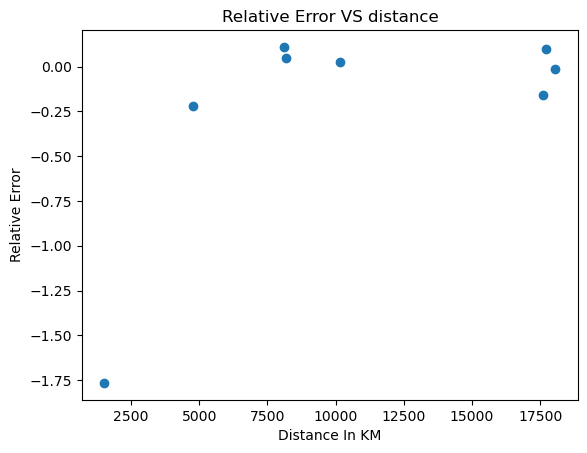

In [24]:
sorted = df.sort_values(by="Distances") #Sorting the data by distance
plt.scatter(sorted["Distances"]/1000, 2*sorted["Residuals"]/sorted["Times"])
plt.xlabel("Distance In KM")
plt.ylabel("Relative Error")
plt.title("Relative Error VS distance")
plt.show()

As we can see, the closest server in berkeley has a very poor relative error. This has been a big source of confusion. I have not removed it to show that there are some outliers. What I think is occuring is that the west coast networks, or the academic networks, have much lower switching latency than the national or international networks, because one of the next graphs will show that with a much smaller estimate for switching latency yeilds an expected time that is inline with the result.

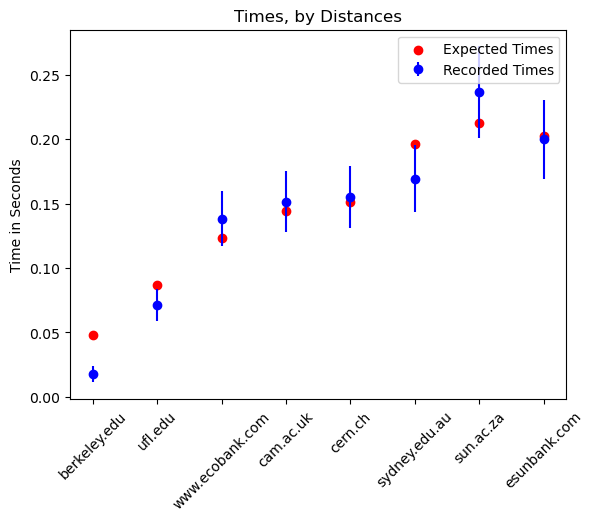

In [25]:
observationErrorBars = sorted["Observation Time Errors"].values
plt.errorbar(sorted.index,sorted["Times"],yerr=observationErrorBars,fmt="o",c="b",label="Recorded Times")
plt.scatter(sorted.index,sorted["Expected Times"],c="r",label="Expected Times")
plt.xticks(rotation=45)
plt.ylabel("Time in Seconds")
plt.title("Times, by Distances")
plt.legend()
plt.show()

Here I graph the expected time in red and the recorded time and error bars in blue. Below I graph the expected time in red and recorded time in blue, but I give a spread based on 1 standard deviation on the parameters I have found. 

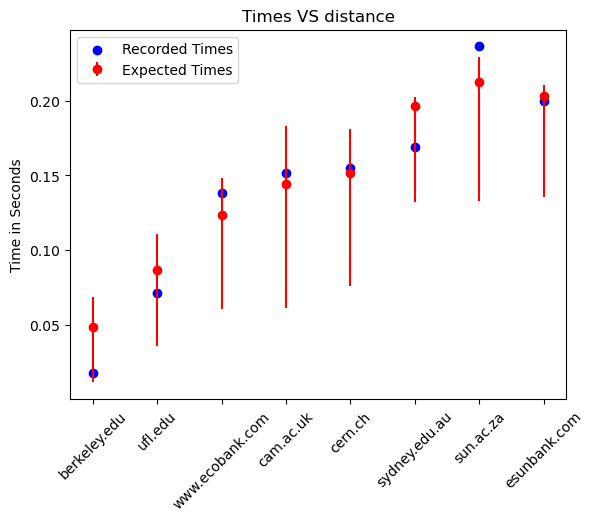

In [26]:
parameterErrorBars = sorted[["Expected Time Low Error Bars","Expected Time High Error Bars"]].values.transpose()
plt.errorbar(sorted.index,sorted["Expected Times"],yerr=parameterErrorBars,fmt="o",c="r",label="Expected Times")
plt.scatter(sorted.index,sorted["Times"],c="b", label="Recorded Times")
plt.xticks(rotation=45)
plt.ylabel("Time in Seconds")
plt.title("Times VS distance")
plt.legend()
plt.show()

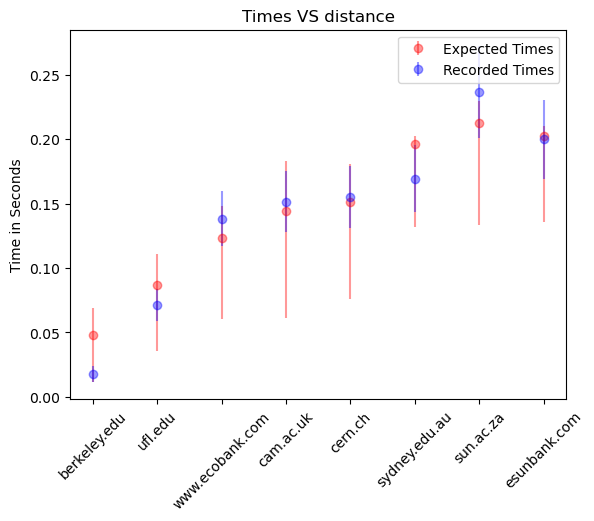

In [27]:
parameterErrorBars = sorted[["Expected Time Low Error Bars","Expected Time High Error Bars"]].values.transpose()
plt.errorbar(sorted.index,sorted["Expected Times"],yerr=parameterErrorBars,fmt="o",c="r",alpha=0.4,label="Expected Times")
plt.errorbar(sorted.index,sorted["Times"],yerr=observationErrorBars,fmt="o",c="b",alpha=0.4,label="Recorded Times")
plt.xticks(rotation=45)
plt.ylabel("Time in Seconds")
plt.title("Times VS distance")
plt.legend()
plt.show()

Above I plot both the parameter error bars and the observation error bars. For all but the berkeley data point, they show a large range of agreement, which to me indicates that somewhere in the parameter range is the true value of 1/c and T_h.

# Discussion of results
My estimation of the speed of light in a fiber optic at $2.27^{+.37}_{-.28}  \times 10^8$ m/s is within about 10% of the actual value at $2.054 \times 10^8$ m/s. My estimations of the uncertainties through the weighted least squares technique has yeiled a statisically sound error propogation for the parameters.

In [28]:
cLowerAndUpperErrors, C, Beta[1]

(array([28221557.14044094, 37456269.11603788]),
 228934966.66043326,
 0.0012507739432999682)